In [1]:
import pandas as pd
import requests
import json
import numpy as np
from scipy import signal
from datetime import datetime

In [2]:
cpi = pd.read_csv('cpi_2000_2023.csv')
print(len(cpi))
cpi.tail(n=10)

404


,DATE,CPI,CPI_PERCENT
394,2022-11-01,297.711,7.1
395,2022-12-01,296.797,6.5
396,2023-01-01,299.170,6.4
397,2023-02-01,300.840,6.0
398,2023-03-01,301.836,5.0
399,2023-04-01,303.363,4.9
400,2023-05-01,304.127,4.0
401,2023-06-01,305.109,3.0
402,2023-07-01,305.691,3.2
403,2023-08-01,307.026,3.7


In [4]:
unrate = pd.read_csv('unemployment_2000_2023.csv')
print(len(unrate))
unrate.tail(n=10)

296


,DATE,UNEMPLOYMENT
286,2022-11-01,3.6
287,2022-12-01,3.5
288,2023-01-01,3.4
289,2023-02-01,3.6
290,2023-03-01,3.5
291,2023-04-01,3.4
292,2023-05-01,3.7
293,2023-06-01,3.6
294,2023-07-01,3.5
295,2023-08-01,3.8


In [5]:
effr = pd.read_csv('effr_2000_2023.csv')
print(len(effr))
effr.tail(n=10)

278


,DATE,EFFR
268,2022-11-01,3.83
269,2022-12-01,4.33
270,2023-01-01,4.33
271,2023-02-01,4.57
272,2023-03-01,4.83
273,2023-04-01,4.83
274,2023-05-01,5.08
275,2023-06-01,5.08
276,2023-07-01,5.33
277,2023-08-01,5.33


In [11]:
merged = unrate.merge(cpi, on='DATE')
merged = merged.merge(effr, on='DATE')

unrate_col = merged.pop('UNEMPLOYMENT')
effr_col = merged.pop('EFFR')

merged['UNEMPLOYMENT'] = unrate_col
merged['EFFR'] = effr_col

merged = merged.drop(['CPI'], axis=1)
merged.dropna(inplace=True)
print(len(merged))
merged.tail()

278


,DATE,CPI_PERCENT,UNEMPLOYMENT,EFFR
273,2023-04-01,4.9,3.4,4.83
274,2023-05-01,4.0,3.7,5.08
275,2023-06-01,3.0,3.6,5.08
276,2023-07-01,3.2,3.5,5.33
277,2023-08-01,3.7,3.8,5.33


In [30]:
# merged2 = pd.melt(merged, id_vars=['DATE'], var_name=['SIGNAL'], value_name='VALUE', ignore_index = False)
# merged2.sort_values(by=['DATE'], inplace=True)
# merged2.reset_index(drop=True, inplace=True)
# print(len(merged2))
# merged2.tail(n=10)

<Axes: xlabel='EFFR', ylabel='CPI_PERCENT'>

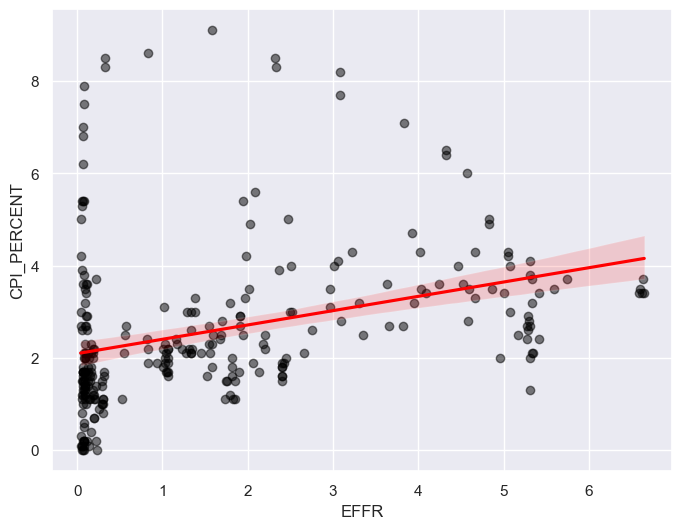

In [14]:
fig = plt.figure(figsize = (8, 6))
sns.regplot(x = merged['EFFR'], y = merged['CPI_PERCENT'],
            scatter_kws = {"color": "black", "alpha": 0.5},
            line_kws = {"color": "red"})

In [15]:
x = merged['EFFR']
y = merged['CPI_PERCENT']
correlation = signal.correlate(x, y, mode="full")
lags = signal.correlation_lags(x.size, y.size, mode="full")
lag = lags[np.argmax(correlation)]
lag

0

In [16]:
x = merged['EFFR']
y = merged['UNEMPLOYMENT']
correlation = signal.correlate(x, y, mode="full")
lags = signal.correlation_lags(x.size, y.size, mode="full")
lag = lags[np.argmax(correlation)]
lag

-42

In [17]:
x = merged['CPI_PERCENT']
y = merged['UNEMPLOYMENT']
correlation = signal.correlate(x, y, mode="full")
lags = signal.correlation_lags(x.size, y.size, mode="full")
lag = lags[np.argmax(correlation)]
lag

19

In [18]:
import numpy as np
from scipy import signal
rng = np.random.default_rng()
x = rng.standard_normal(1000)
y = np.concatenate([rng.standard_normal(100), x])
correlation = signal.correlate(x, y, mode="full")
lags = signal.correlation_lags(x.size, y.size, mode="full")
lag = lags[np.argmax(correlation)]
lag

-100

In [19]:
def ccf_values(series1, series2):
    p = series1
    q = series2
    p = (p - np.mean(p)) / (np.std(p) * len(p))
    q = (q - np.mean(q)) / (np.std(q))  
    c = np.correlate(p, q, 'full')
    return c
    
ccf_effr_cpi = ccf_values(merged['EFFR'], merged['CPI_PERCENT'])

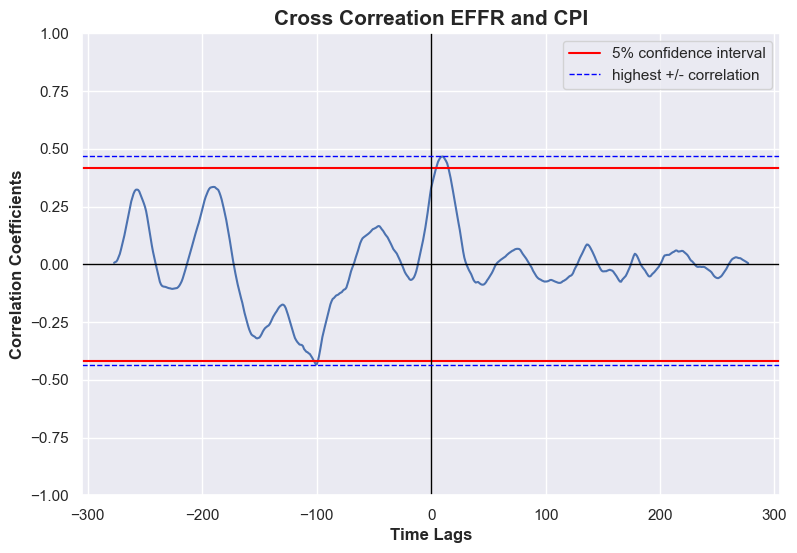

In [20]:
lags = signal.correlation_lags(len(merged['EFFR']), len(merged['CPI_PERCENT']))
def ccf_plot(lags, ccf):
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.plot(lags, ccf)
    ax.axhline(-2/np.sqrt(23), color='red', label='5% confidence interval')
    ax.axhline(2/np.sqrt(23), color='red')
    ax.axvline(x = 0, color = 'black', lw = 1)
    ax.axhline(y = 0, color = 'black', lw = 1)
    ax.axhline(y = np.max(ccf), color = 'blue', lw = 1, 
    linestyle='--', label = 'highest +/- correlation')
    ax.axhline(y = np.min(ccf), color = 'blue', lw = 1, 
    linestyle='--')
    ax.set(ylim = [-1, 1])
    ax.set_title('Cross Correation EFFR and CPI', weight='bold', fontsize = 15)
    ax.set_ylabel('Correlation Coefficients', weight='bold', 
    fontsize = 12)
    ax.set_xlabel('Time Lags', weight='bold', fontsize = 12)
    plt.legend()
    
ccf_plot(lags, ccf_effr_cpi)

In [22]:
import numpy as np

from bokeh.layouts import column
from bokeh.models import ColumnDataSource, RangeTool
from bokeh.plotting import figure
from bokeh.io import output_notebook, show

output_notebook()

TOOLS = "pan,wheel_zoom,box_zoom,reset,save,box_select"

dates = np.array(merged['DATE'], dtype=np.datetime64)
effr_src = ColumnDataSource(data=dict(date=dates, rate=merged['EFFR']))
cpi_src = ColumnDataSource(data=dict(date=dates, rate=merged['CPI_PERCENT']))
unemp_src = ColumnDataSource(data=dict(date=dates, rate=merged['UNEMPLOYMENT']))

p = figure(height=300, sizing_mode='stretch_width', tools="xpan", toolbar_location=None,
           x_axis_type="datetime", x_axis_location="above",
           background_fill_color="#efefef", x_range=(dates[0], dates[50]),)

p.line('date', 'rate', source=effr_src, color='blue', legend_label='Federal Funds Effective Rate')
p.line('date', 'rate', source=cpi_src, color='red', legend_label='CPI for All Urban Consumers (CPI-U)')
p.line('date', 'rate', source=unemp_src, color='green', legend_label='Unemployment Rate')
p.yaxis.axis_label = 'Rate'

select = figure(title="Drag the middle and edges of the selection box to change the range above",
                height=130, width=800, y_range=p.y_range,
                x_axis_type="datetime", y_axis_type=None,
                toolbar_location=None, background_fill_color="#efefef")

range_tool = RangeTool(x_range=p.x_range)
range_tool.overlay.fill_color = "navy"
range_tool.overlay.fill_alpha = 0.2

select.line('date', 'rate', source=effr_src, color='blue')
select.line('date', 'rate', source=cpi_src, color='red')
select.line('date', 'rate', source=unemp_src, color='green')
select.ygrid.grid_line_color = None
select.add_tools(range_tool)

show(column(p, select))

Loading BokehJS ...

<Axes: xlabel='EFFR', ylabel='CPI_PERCENT'>

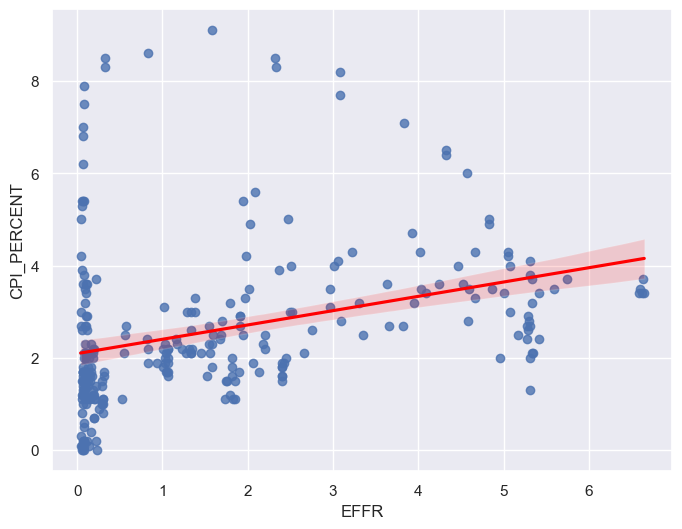

In [23]:
fig = plt.figure(figsize = (8, 6))
sns.regplot(x = merged['EFFR'], y = merged['CPI_PERCENT'],
#             scatter_kws = {"color": "black", "alpha": 0.5},
            line_kws = {"color": "red"})

<Axes: xlabel='EFFR', ylabel='UNEMPLOYMENT'>

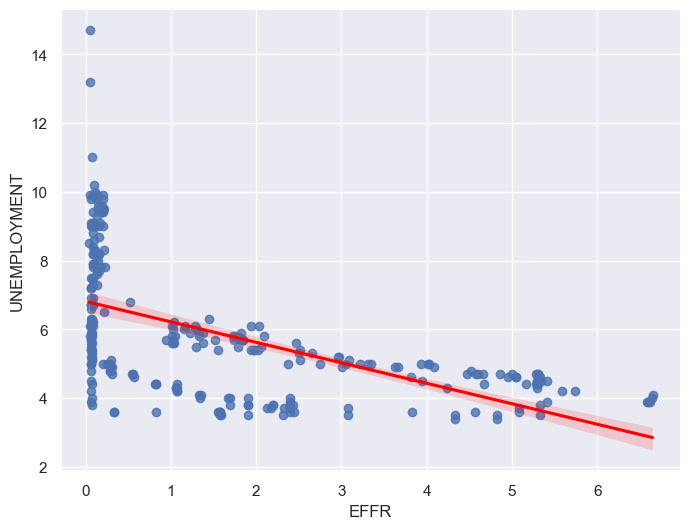

In [24]:
fig = plt.figure(figsize = (8, 6))
sns.regplot(x = merged['EFFR'], y = merged['UNEMPLOYMENT'],
#             scatter_kws = {"color": "black", "alpha": 0.5},
            line_kws = {"color": "red"})

In [25]:
merged['EFFR'].corr(merged['CPI_PERCENT'])


0.330535761041365

In [26]:
merged['EFFR'].corr(merged['UNEMPLOYMENT'])

-0.5587227803665135

In [28]:
ccf_effr_cpi = ccf_values(merged['EFFR'], merged['CPI_PERCENT'])

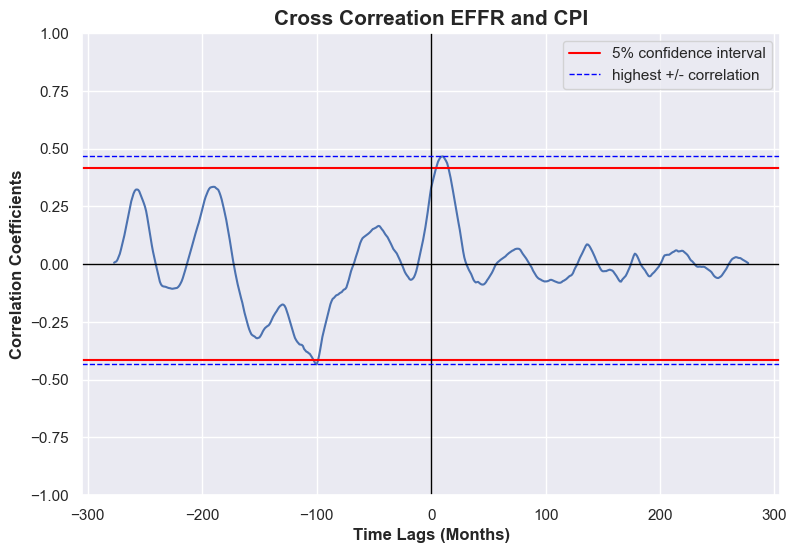

In [29]:
lags = signal.correlation_lags(len(merged['EFFR']), len(merged['CPI_PERCENT']))

def ccf_plot(lags, ccf):
    fig, ax =plt.subplots(figsize=(9, 6))
    ax.plot(lags, ccf)
    ax.axhline(-2/np.sqrt(23), color='red', label='5% confidence interval')
    ax.axhline(2/np.sqrt(23), color='red')
    ax.axvline(x = 0, color = 'black', lw = 1)
    ax.axhline(y = 0, color = 'black', lw = 1)
    ax.axhline(y = np.max(ccf), color = 'blue', lw = 1, linestyle='--', label = 'highest +/- correlation')
    ax.axhline(y = np.min(ccf), color = 'blue', lw = 1, linestyle='--')
    ax.set(ylim = [-1, 1])
    ax.set_title('Cross Correation EFFR and CPI', weight='bold', fontsize = 15)
    ax.set_ylabel('Correlation Coefficients', weight='bold', fontsize = 12)
    ax.set_xlabel('Time Lags (Months)', weight='bold', fontsize = 12)
    plt.legend()
    
ccf_plot(lags, ccf_effr_cpi)